In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras.layers.convolutional import Conv1D

from keras.optimizers import Adam
from keras.models import Model
import keras.initializers as KI
from keras.layers import Dense, Dropout, Input, LeakyReLU
from keras.models import Sequential
from tensorflow import set_random_seed

np.random.seed(42)
set_random_seed(42)
%matplotlib inline

Using TensorFlow backend.


In [2]:
#load the corss validation set
train = pickle.load(open('../data/train_preprocessed.pkl','rb'))
test = pickle.load(open('../data/test_preprocessed.pkl','rb'))
test_pre_pred = pickle.load(open('../data/test_predicted.pkl','rb'))
labels = pickle.load(open('../data/labels_preprocessed.pkl','rb'))

## Utility Functions

In [3]:
def GetMicroAccuracy(labels, predictions):
    predictions = np.where(predictions >= 0.5, 1, 0)
    _val_f1 = f1_score(labels, predictions, average='micro')
    _val_recall = recall_score(labels, predictions, average='micro')
    _val_precision = precision_score(labels, predictions, average='micro')
    print ("[Weighted] F1 Score: %f,  Precision: %f,  Recall: %f" % (_val_f1, _val_precision, _val_recall))

In [4]:
import logging
from sklearn.metrics import roc_auc_score, f1_score
from keras.callbacks import Callback

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("- ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

class F1Evaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = f1_score(self.y_val, np.where(y_pred >= 0.5, 1, 0), average='micro')
            print("- F1-micro (0.5 threshold) - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [5]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
#calculat the class weights:  2d array (# of classes (ROWS), 2 * (background and signal))
def calculating_class_weights(y_true):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights

#custom loss function
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), 
                      axis=-1)
    return weighted_loss

## TF-IDF Data Prep

In [7]:
vect = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,3), min_df=5e-4)
x = vect.fit_transform(train.doc_text)
pickle.dump(x, open('../data/tfidf_5k_train.pkl','wb'))
x_test = vect.transform(test.doc_text)
pickle.dump(x_test, open('../data/tfidf_5k_test.pkl','wb'))

vect = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,3), min_df=5e-4)
x = vect.fit_transform(train.doc_text)
pickle.dump(x, open('../data/tfidf_10k_train.pkl','wb'))
x_test = vect.transform(test.doc_text)
pickle.dump(x_test, open('../data/tfidf_10k_test.pkl','wb'))

## Rebalancing Preperation

In [8]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MultiLabelBinarizer
from imblearn.under_sampling import RandomUnderSampler

def get_col_list(rowid):
    tlist = []
    for _col in labels.columns:
        if labels.loc[rowid][_col] == 1:
            tlist.extend([_col])
    return tlist

train = train.reset_index()
train['labels_combined'] = train.row_id.map(lambda x: get_col_list(x))
train = train.set_index('row_id')

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(train.labels_combined)
Y = multilabel_binarizer.transform(train.labels_combined)
train.drop(columns=['labels_combined'], inplace=True)

## Undersampling / Class-Balance (RandomUnderSampler)

In [9]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_resample, y_resample = rus.fit_sample(x, Y)
print("size after first UnderSample:", X_resample.shape)
X_resample, y_resample = rus.fit_sample(X_resample, y_resample)
print("size after second UnderSample:", X_resample.shape)
X_resample, y_resample = rus.fit_sample(X_resample, y_resample)
print("size after third UnderSample:", X_resample.shape)
X_resample, y_resample = rus.fit_sample(X_resample, y_resample)
print("size after fourth UnderSample:", X_resample.shape)
#X_resample, y_resample = rus.fit_sample(X_resample, y_resample)
#print("size after fifth UnderSample:", X_resample.shape)

size after first UnderSample: (13354, 5000)
size after second UnderSample: (11418, 5000)
size after third UnderSample: (9904, 5000)
size after fourth UnderSample: (8663, 5000)


## Oversampling / Class-Balance (RandomOverSampler) - leads to over fitting

In [10]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MultiLabelBinarizer

ros = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_resample, y_resample = ros.fit_sample(X_resample, y_resample)
print("size after first OverSample:", X_resample.shape)
X_resample, y_resample = ros.fit_sample(X_resample, y_resample)
print("size after second OverSample:", X_resample.shape)
X_resample, y_resample = ros.fit_sample(X_resample, y_resample)
print("size after third OverSample:", X_resample.shape)

#put the labels back in order of submission
cols = list(multilabel_binarizer.classes_)
Y_test = pd.DataFrame(y_resample)
Y_test.columns = cols
Y_test = Y_test[labels.columns.tolist()]  #re-order the columns for prediction / submission
y_resample = Y_test.values.astype(np.uint8)

size after first OverSample: (9862, 5000)
size after second OverSample: (11061, 5000)
size after third OverSample: (12260, 5000)


## Test-Train split if you want...

In [11]:
X_resample_trn, X_resample_val, y_resample_trn, y_resample_val = train_test_split(X_resample, 
        y_resample, test_size=0.2, random_state=42)

## <font color="Red">Keras </font> Model

In [12]:
#class_wt = calculating_class_weights(labels.values)
#from sklearn.utils import class_weight
#class_wt = class_weight.compute_sample_weight('balanced', labels.values)

opt = Adam(lr=0.1e-2)
init = KI.lecun_uniform(seed=np.random.randint(1,100+1))  #LeCun uniform initializer

K_model = Sequential()
K_model.add(Dense(4000, kernel_initializer=init, input_dim=5000, activation='relu'))
K_model.add(Dropout(0.5))

K_model.add(Dense(2500, kernel_initializer=init))
K_model.add(LeakyReLU(0.2))
K_model.add(Dropout(0.5))

K_model.add(Dense(1200, kernel_initializer=init, activation='relu'))
K_model.add(Dropout(0.5))

K_model.add(Dense(500, kernel_initializer=init, activation='relu'))
K_model.add(Dropout(0.5))

K_model.add(Dense(29, kernel_initializer=init, activation='sigmoid'))

f1_val = F1Evaluation(validation_data=(X_resample_val, y_resample_val), interval = 1)

K_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',f1])
#K_model.compile(loss=get_weighted_loss(class_wt), optimizer=opt, metrics=['accuracy',f1])


history = K_model.fit(X_resample_trn, y_resample_trn, epochs=7, batch_size=500,
                      verbose=1, validation_data=(X_resample_val, y_resample_val))

predictions = K_model.predict(X_resample_val).round().astype(np.uint8)
GetMicroAccuracy(y_resample_val, predictions)

Train on 9808 samples, validate on 2452 samples
Epoch 1/7
9808/9808 [==============================] - 6s 565us/step - loss: 0.2836 - acc: 0.9304 - f1: 0.0381 - val_loss: 0.1349 - val_acc: 0.9655 - val_f1: 0.0000e+00
Epoch 2/7
9808/9808 [==============================] - 2s 194us/step - loss: 0.1354 - acc: 0.9666 - f1: 0.0896 - val_loss: 0.1045 - val_acc: 0.9722 - val_f1: 0.3274
Epoch 3/7
9808/9808 [==============================] - 2s 194us/step - loss: 0.1004 - acc: 0.9748 - f1: 0.4324 - val_loss: 0.0870 - val_acc: 0.9753 - val_f1: 0.4450
Epoch 4/7
9808/9808 [==============================] - 2s 193us/step - loss: 0.0861 - acc: 0.9765 - f1: 0.4905 - val_loss: 0.0726 - val_acc: 0.9786 - val_f1: 0.5633
Epoch 5/7
9808/9808 [==============================] - 2s 194us/step - loss: 0.0706 - acc: 0.9789 - f1: 0.5902 - val_loss: 0.0611 - val_acc: 0.9805 - val_f1: 0.6410
Epoch 6/7
9808/9808 [==============================] - 2s 195us/step - loss: 0.0583 - acc: 0.9816 - f1: 0.6735 - val_loss: 

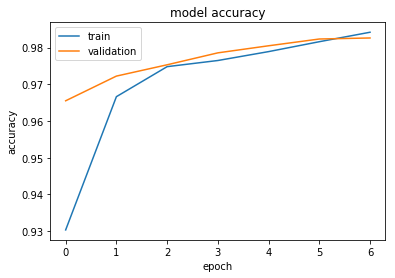

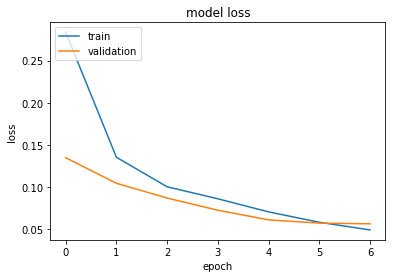

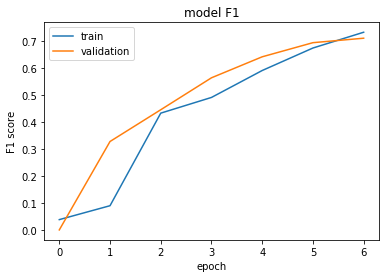

In [14]:
#score pre-clean up was F1 Score: 0.638791,  Precision: 0.660417,  Recall: 0.618537
#sclre after cleanup (#1) and added dropout : F1 Score: 0.640349,  Precision: 0.676375,  Recall: 0.607967
# 6000 TFIDF : F1 Score: 0.641271,  Precision: 0.664054,  Recall: 0.620000
# 7500 TFIDF : 

# list all data in history
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation','f1'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# show the F1 vs val_f1
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model F1')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


# Try Predictions

In [20]:
#get all train data, perform updates, train model fully
X_resample, y_resample = rus.fit_sample(x, Y)
print("size after first UnderSample:", X_resample.shape)
X_resample, y_resample = rus.fit_sample(X_resample, y_resample)
print("size after second UnderSample:", X_resample.shape)
X_resample, y_resample = rus.fit_sample(X_resample, y_resample)
print("size after third UnderSample:", X_resample.shape)
X_resample, y_resample = rus.fit_sample(X_resample, y_resample)
print("size after fourth UnderSample:", X_resample.shape)

X_resample, y_resample = ros.fit_sample(X_resample, y_resample)
print("size after first OverSample:", X_resample.shape)
X_resample, y_resample = ros.fit_sample(X_resample, y_resample)
print("size after second OverSample:", X_resample.shape)
X_resample, y_resample = ros.fit_sample(X_resample, y_resample)
print("size after third OverSample:", X_resample.shape)

opt = Adam(lr=0.1e-2)
init = KI.lecun_uniform(seed=np.random.randint(1,100+1))  #LeCun uniform initializer

K_model = Sequential()
K_model.add(Dense(4000, kernel_initializer=init, input_dim=5000, activation='relu'))
K_model.add(Dropout(0.5))

K_model.add(Dense(2500, kernel_initializer=init))
K_model.add(LeakyReLU(0.2))
K_model.add(Dropout(0.5))

K_model.add(Dense(1200, kernel_initializer=init, activation='relu'))
K_model.add(Dropout(0.5))

K_model.add(Dense(500, kernel_initializer=init, activation='relu'))
K_model.add(Dropout(0.5))

K_model.add(Dense(29, kernel_initializer=init, activation='sigmoid'))

K_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy',f1])

K_model.fit(X_resample, y_resample, epochs=25, batch_size=500, verbose=1)

size after first UnderSample: (13354, 5000)
size after second UnderSample: (11418, 5000)
size after third UnderSample: (9904, 5000)
size after fourth UnderSample: (8663, 5000)
size after first OverSample: (9862, 5000)
size after second OverSample: (11061, 5000)
size after third OverSample: (12260, 5000)
Epoch 1/25
12260/12260 [==============================] - 4s 349us/step - loss: 0.2558 - acc: 0.9383 - f1: 0.0284
Epoch 2/25
12260/12260 [==============================] - 2s 182us/step - loss: 0.1181 - acc: 0.9707 - f1: 0.2542
Epoch 3/25
12260/12260 [==============================] - 2s 181us/step - loss: 0.0918 - acc: 0.9758 - f1: 0.4638
Epoch 4/25
12260/12260 [==============================] - 2s 181us/step - loss: 0.0720 - acc: 0.9788 - f1: 0.5836
Epoch 5/25
12260/12260 [==============================] - 2s 182us/step - loss: 0.0566 - acc: 0.9827 - f1: 0.69780s - loss: 0.0569 - acc: 0.9826 
Epoch 6/25
12260/12260 [==============================] - 2s 182us/step - loss: 0.0470 - acc:

In [21]:
#try a prediction
predictions = K_model.predict(x_test)

In [22]:
sub = test.copy()
sub.drop(columns=['doc_text'], inplace=True)
for _col in labels.columns.tolist():
    sub[_col] = np.uint8(0)

sub[:] = predictions

In [23]:
for label in sub.columns:
    pltme = pd.Series(sub[label].values, name=label)
    in_group = np.where(pltme >= 0.5, 1, 0).sum()
    print('Total for "%s" is %s' % (label, in_group))

Total for "information_and_communication_technologies" is 2392
Total for "governance" is 53
Total for "urban_development" is 1269
Total for "law_and_development" is 398
Total for "public_sector_development" is 1
Total for "agriculture" is 2488
Total for "communities_and_human_settlements" is 6
Total for "health_and_nutrition_and_population" is 0
Total for "culture_and_development" is 419
Total for "environment" is 1361
Total for "social_protections_and_labor" is 1438
Total for "industry" is 1506
Total for "macroeconomics_and_economic_growth" is 113
Total for "international_economics_and_trade" is 284
Total for "conflict_and_development" is 47
Total for "finance_and_financial_sector_development" is 778
Total for "science_and_technology_development" is 630
Total for "rural_development" is 1501
Total for "poverty_reduction" is 563
Total for "private_sector_development" is 133
Total for "informatics" is 128
Total for "energy" is 93
Total for "social_development" is 0
Total for "water_resou

In [24]:
#show if there are any rows that have NO prediction
xxx = sub.copy()
xxx[:] = np.where(xxx[:].values >= 0.5, 1, 0).astype(np.uint8)
xxx = pd.DataFrame(xxx.sum(axis=1))
xxx.columns = ['cnt']
msg_idx = xxx[(xxx.cnt < 1)].index.values
sub[(sub.index.isin(msg_idx))]
xxx[(xxx.cnt == 0)]

,cnt
row_id,
0,0
8,0
22,0
33,0
42,0
45,0
50,0
52,0
59,0


In [ ]:
#save the probability distributions for our future stacking
sub = pd.concat([sub,test_pre_pred]).sort_values(by='row_id')
sub.to_csv('../submissions/proba/TFIDF-DNN_10k_3gram_OverSample2.csv')

#convert to 1 / 0 output and save for submission
sub[:] = np.where(sub[:].values >= 0.5, 1, 0).astype(np.uint8)
sub.to_csv('../submissions/TFIDF-DNN_10k_3gram_OverSample2.csv')